# Prediksi Kebangkrutan Bank di Taiwan
## Tugas Akhir - Pertemuan 11

**Studi Kasus:**
Bank Sentral Taiwan memerlukan sistem prediksi untuk mengidentifikasi bank yang berpotensi mengalami kebangkrutan (bankruptcy). Sebagai data analyst, tugas kita adalah:
1. Mengidentifikasi indikator kesehatan bank yang paling berpengaruh
2. Membangun model machine learning untuk prediksi kebangkrutan

**Dataset:** Data historis kesehatan bank dengan berbagai indikator finansial

---

## 1. BUSINESS UNDERSTANDING

### 1.1 Permasalahan yang Dihadapi Bank Sentral Taiwan

**Masalah Utama:**
- Bank Sentral Taiwan bertanggung jawab mengawasi dan meregulasi industri perbankan
- Perlu mengidentifikasi bank yang berisiko bangkrut **sebelum** terlambat
- Tanpa prediksi dini, bank bisa kolaps dan menimbulkan efek domino pada ekonomi

**Mengapa Predictive Analytics Diperlukan?**
1. **Deteksi Dini:** Mengidentifikasi bank bermasalah sebelum bangkrut
2. **Preventif:** Memberikan waktu untuk intervensi dan pendampingan
3. **Efisiensi:** Fokus sumber daya pada bank yang benar-benar memerlukan perhatian
4. **Stabilitas Ekonomi:** Mencegah krisis sistemik di sektor perbankan

**Kontribusi Project:**
- ✅ Sistem early warning untuk kebangkrutan bank
- ✅ Identifikasi indikator kesehatan bank yang kritis
- ✅ Rekomendasi berbasis data untuk regulasi perbankan
- ✅ Optimalisasi alokasi sumber daya pengawasan

---

In [19]:
# Install required packages
import sys
import subprocess

packages = ['imbalanced-learn', 'tensorflow', 'seaborn']
print("📦 Mengecek dan menginstall package yang diperlukan...")
for package in packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"✅ {package} sudah terinstall")
    except ImportError:
        print(f"⏳ Menginstall {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✅ {package} berhasil diinstall")
print("\n" + "="*70)

📦 Mengecek dan menginstall package yang diperlukan...
⏳ Menginstall imbalanced-learn...
✅ imbalanced-learn berhasil diinstall
✅ tensorflow sudah terinstall
✅ seaborn sudah terinstall

✅ imbalanced-learn berhasil diinstall
✅ tensorflow sudah terinstall
✅ seaborn sudah terinstall



In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Semua library berhasil diimport!")
print("="*70)

✅ Semua library berhasil diimport!


## 2. DATA UNDERSTANDING

### 2.1 Load Dataset dan Informasi Dasar

In [21]:
# Load the data
df = pd.read_csv('data-bank.csv')

# Display basic information
print("="*70)
print("INFORMASI DATASET")
print("="*70)
print(f"Jumlah baris dan kolom: {df.shape}")
print(f"Total jumlah data: {df.shape[0] * df.shape[1]:,} data points")

print(f"\n{'='*70}")
print("PREVIEW DATA (5 Baris Pertama)")
print("="*70)
print(df.head())

print(f"\n{'='*70}")
print("INFORMASI KOLOM DAN TIPE DATA")
print("="*70)
print(df.info())

# Check for missing values
print(f"\n{'='*70}")
print("MISSING VALUES")
print("="*70)
missing_total = df.isnull().sum().sum()
if missing_total == 0:
    print("✅ Tidak ada missing values dalam dataset")
else:
    print(f"⚠️ Total missing values: {missing_total}")
    print(df.isnull().sum()[df.isnull().sum() > 0])

# Statistical summary
print(f"\n{'='*70}")
print("STATISTIK DESKRIPTIF")
print("="*70)
print(df.describe().T)

INFORMASI DATASET
Jumlah baris dan kolom: (6819, 96)
Total jumlah data: 654,624 data points

PREVIEW DATA (5 Baris Pertama)
   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                       

### 2.2 Target Variable

**Target Variable:** `Bankrupt?`
- **0:** Bank masih beroperasi (sehat)
- **1:** Bank mengalami kebangkrutan

Mari kita analisis distribusi target variable:

Class Distribution:
Bankrupt?
0    6599
1     220
Name: count, dtype: int64

Percentage:
Bankrupt?
0    96.77372
1     3.22628
Name: proportion, dtype: float64


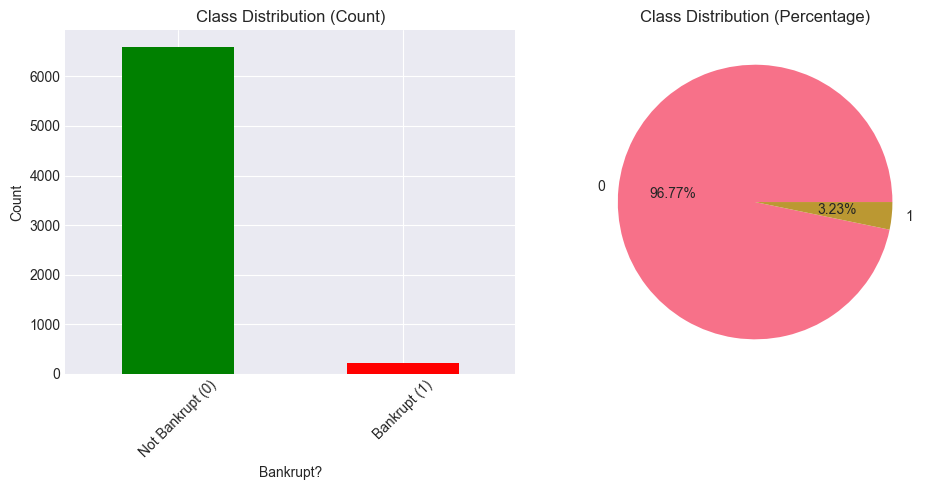


Imbalance Ratio: 30.00:1


In [22]:
# Check class distribution
print("Class Distribution:")
print(df['Bankrupt?'].value_counts())
print("\nPercentage:")
print(df['Bankrupt?'].value_counts(normalize=True) * 100)

# Visualize the imbalance
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['Bankrupt?'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution (Count)')
plt.xlabel('Bankrupt?')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Bankrupt (0)', 'Bankrupt (1)'], rotation=45)

plt.subplot(1, 2, 2)
df['Bankrupt?'].value_counts().plot(kind='pie', autopct='%1.2f%%', color=['green', 'red'])
plt.title('Class Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

print(f"\nImbalance Ratio: {df['Bankrupt?'].value_counts()[0] / df['Bankrupt?'].value_counts()[1]:.2f}:1")

### 2.3 Exploratory Data Analysis (EDA)

Analisis hubungan antara beberapa variabel dengan target variable untuk memahami pola kebangkrutan:

KeyError: 'ROA(C) before interest and depreciation before interest'

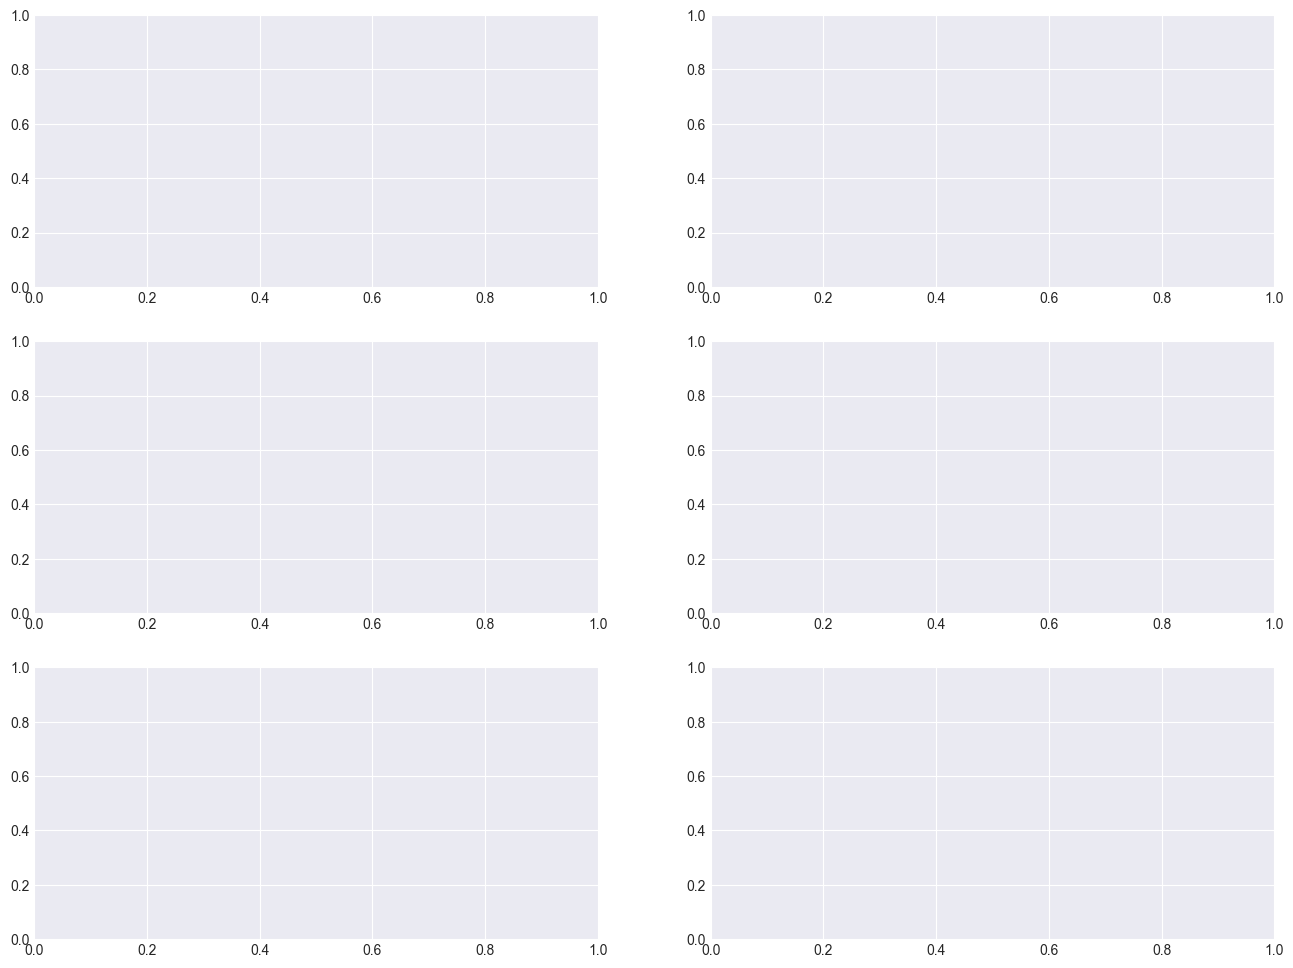

In [23]:
# Pilih beberapa variabel penting untuk analisis
important_vars = [
    'ROA(C) before interest and depreciation before interest',
    'Operating Profit Rate',
    'Debt ratio %',
    'Net Value Per Share (B)',
    'Current Ratio',
    'Quick Ratio'
]

# Visualisasi distribusi variabel penting vs target
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, var in enumerate(important_vars):
    # Box plot untuk membandingkan distribusi
    bankrupt_data = df[df['Bankrupt?'] == 1][var]
    healthy_data = df[df['Bankrupt?'] == 0][var]
    
    axes[idx].boxplot([healthy_data, bankrupt_data], 
                      labels=['Sehat (0)', 'Bangkrut (1)'],
                      patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2))
    
    axes[idx].set_title(f'{var}', fontweight='bold', fontsize=10)
    axes[idx].set_ylabel('Nilai')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Tambahkan statistik
    mean_healthy = healthy_data.mean()
    mean_bankrupt = bankrupt_data.mean()
    axes[idx].text(0.02, 0.98, f'Mean Sehat: {mean_healthy:.4f}\nMean Bangkrut: {mean_bankrupt:.4f}',
                  transform=axes[idx].transAxes,
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                  fontsize=8)

plt.suptitle('Perbandingan Indikator Finansial: Bank Sehat vs Bangkrut', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Correlation heatmap untuk top features
plt.figure(figsize=(12, 10))

# Hitung korelasi dengan target
correlations = df.corr()['Bankrupt?'].sort_values(ascending=False)
top_features = correlations.abs().nlargest(16).index.tolist()

# Buat heatmap
correlation_matrix = df[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=1, cbar_kws={'label': 'Korelasi'})
plt.title('Korelasi Top 15 Features dengan Target Variable', 
          fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Tampilkan korelasi tertinggi dengan target
print("="*70)
print("TOP 15 VARIABEL BERKORELASI DENGAN KEBANGKRUTAN")
print("="*70)
print(correlations.head(15).to_string())

---

## 3. DATA PREPARATION

### 3.1 Analisis Balance Dataset

**Pertanyaan:** Apakah data ini balance?

Mari kita cek distribusi kelas target:

In [ ]:
# Separate features and target
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data BEFORE balancing (important!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())

Features shape: (6819, 95)
Target shape: (6819,)

Training set size: 5455
Test set size: 1364

Training set class distribution:
Bankrupt?
0    5279
1     176
Name: count, dtype: int64


### 3.2 Handling Imbalanced Data

**Kesimpulan:** Dataset sangat **TIDAK BALANCE** (rasio ~30:1)

**Dampak jika tidak ditangani:**
- Model akan bias terhadap kelas mayoritas (bank sehat)
- Gagal mendeteksi bank yang bangkrut (kelas yang lebih penting!)
- Akurasi tinggi tapi tidak berguna

**Solusi:** Kita akan menggunakan beberapa teknik balancing dan membandingkan hasilnya.

### 3.3 Data Cleaning & Transformation

#### Tahapan:
1. **Handling Missing Values** ✅ (Sudah dicek, tidak ada)
2. **Handling Outliers** (Akan ditangani oleh model ensemble)
3. **Feature Scaling** (Akan dilakukan sebelum training)
4. **Balancing Dataset** (Teknik over-sampling dan under-sampling)

#### Teknik Balancing yang Akan Digunakan:
1. **Random Over-Sampling**: Duplikasi sampel kelas minoritas
2. **SMOTE**: Buat sampel sintetis berbasis k-NN
3. **ADASYN**: Sampling adaptif untuk area sulit
4. **SMOTE + Tomek Links**: Kombinasi over-sampling + pembersihan
5. **SMOTE + ENN**: Kombinasi SMOTE + Edited Nearest Neighbors

In [ ]:
# Store original training data
print("Original training set distribution:")
print(Counter(y_train))

# Dictionary to store all balanced datasets
balanced_datasets = {}

# 1. Random Over-Sampling
print("\n1. Random Over-Sampling...")
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
balanced_datasets['Random Over-Sampling'] = (X_train_ros, y_train_ros)
print(f"After ROS: {Counter(y_train_ros)}")

# 2. SMOTE (Synthetic Minority Over-sampling Technique)
print("\n2. SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
balanced_datasets['SMOTE'] = (X_train_smote, y_train_smote)
print(f"After SMOTE: {Counter(y_train_smote)}")

# 3. ADASYN (Adaptive Synthetic Sampling)
print("\n3. ADASYN...")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
balanced_datasets['ADASYN'] = (X_train_adasyn, y_train_adasyn)
print(f"After ADASYN: {Counter(y_train_adasyn)}")

# 4. Random Under-Sampling
print("\n4. Random Under-Sampling...")
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
balanced_datasets['Random Under-Sampling'] = (X_train_rus, y_train_rus)
print(f"After RUS: {Counter(y_train_rus)}")

# 5. SMOTE + Tomek Links
print("\n5. SMOTE + Tomek Links...")
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)
balanced_datasets['SMOTE + Tomek'] = (X_train_st, y_train_st)
print(f"After SMOTE + Tomek: {Counter(y_train_st)}")

# 6. SMOTE + ENN
print("\n6. SMOTE + ENN...")
smote_enn = SMOTEENN(random_state=42)
X_train_se, y_train_se = smote_enn.fit_resample(X_train, y_train)
balanced_datasets['SMOTE + ENN'] = (X_train_se, y_train_se)
print(f"After SMOTE + ENN: {Counter(y_train_se)}")

print("\n✓ All balancing techniques applied successfully!")

Original training set distribution:
Counter({0: 5279, 1: 176})

1. Random Over-Sampling...
After ROS: Counter({0: 5279, 1: 5279})

2. SMOTE...
After SMOTE: Counter({0: 5279, 1: 5279})

3. ADASYN...
After ADASYN: Counter({1: 5305, 0: 5279})

4. Random Under-Sampling...
After RUS: Counter({0: 176, 1: 176})

5. SMOTE + Tomek Links...
After SMOTE: Counter({0: 5279, 1: 5279})

3. ADASYN...
After ADASYN: Counter({1: 5305, 0: 5279})

4. Random Under-Sampling...
After RUS: Counter({0: 176, 1: 176})

5. SMOTE + Tomek Links...
After SMOTE + Tomek: Counter({0: 5250, 1: 5250})

6. SMOTE + ENN...
After SMOTE + Tomek: Counter({0: 5250, 1: 5250})

6. SMOTE + ENN...
After SMOTE + ENN: Counter({1: 4997, 0: 4341})

✓ All balancing techniques applied successfully!
After SMOTE + ENN: Counter({1: 4997, 0: 4341})

✓ All balancing techniques applied successfully!


## 4. Visualize the Results of Balancing

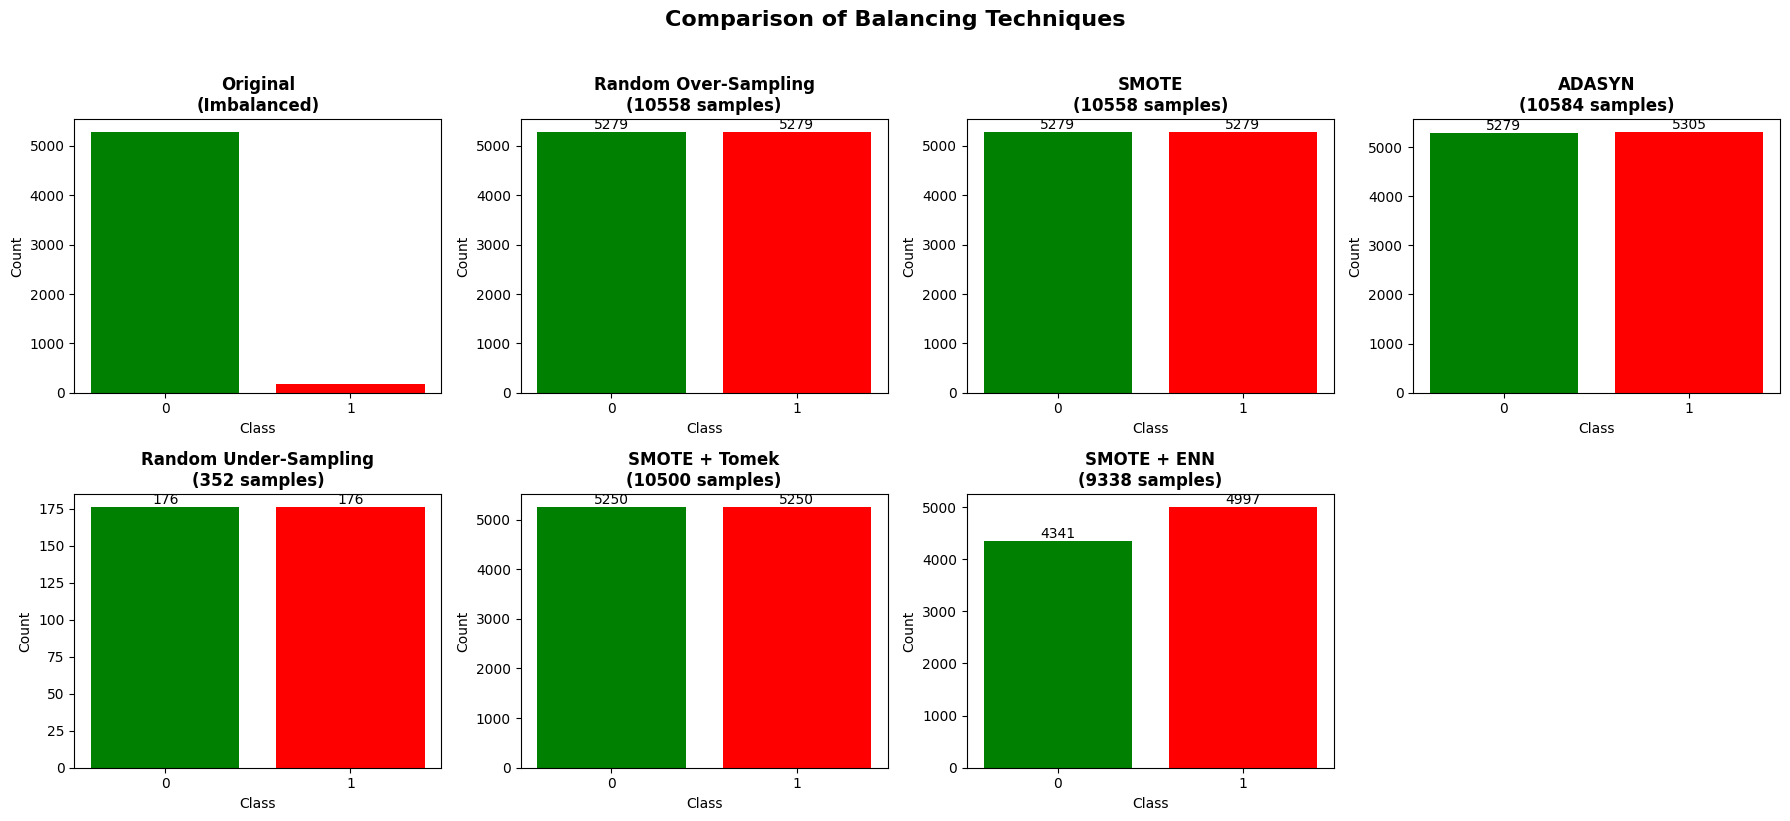

In [ ]:
# Create a comparison visualization
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

# Original data
axes[0].bar([0, 1], Counter(y_train).values(), color=['green', 'red'])
axes[0].set_title('Original\n(Imbalanced)', fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])

# Plot each balanced dataset
for idx, (name, (X_bal, y_bal)) in enumerate(balanced_datasets.items(), 1):
    counts = Counter(y_bal)
    axes[idx].bar([0, 1], counts.values(), color=['green', 'red'])
    axes[idx].set_title(f'{name}\n({len(y_bal)} samples)', fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks([0, 1])
    
    # Add count labels on bars
    for i, (k, v) in enumerate(counts.items()):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')

# Hide the last subplot if not used
if len(balanced_datasets) < 7:
    axes[7].axis('off')

plt.suptitle('Comparison of Balancing Techniques', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 4. MODELING

### 4.1 Model Selection

Kita akan menggunakan 3 algoritma yang diminta:
1. **Decision Tree** - Model berbasis aturan, mudah diinterpretasi
2. **Random Forest** - Ensemble dari banyak decision trees
3. **Artificial Neural Network (ANN)** - Deep learning approach

Setiap model akan dilatih dengan dataset yang sudah di-balance menggunakan teknik terbaik.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score, accuracy_score

# Pilih teknik balancing terbaik (SMOTE) berdasarkan literatur
print("="*70)
print("MENGGUNAKAN SMOTE UNTUK BALANCING")
print("="*70)
X_train_balanced = X_train_smote
y_train_balanced = y_train_smote

print(f"Training set setelah SMOTE: {X_train_balanced.shape}")
print(f"Distribusi kelas: {Counter(y_train_balanced)}")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Dictionary untuk menyimpan hasil
results = {}
trained_models = {}

print(f"\n{'='*70}")
print("TRAINING MODELS")
print("="*70)

# 1. Decision Tree
print("\n1️⃣ Decision Tree Classifier...")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20)
dt_model.fit(X_train_scaled, y_train_balanced)
y_pred_dt = dt_model.predict(X_test_scaled)
trained_models['Decision Tree'] = dt_model

results['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'recall': recall_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt),
    'predictions': y_pred_dt
}
print(f"   ✓ Accuracy: {results['Decision Tree']['accuracy']:.4f}")
print(f"   ✓ F1-Score: {results['Decision Tree']['f1']:.4f}")
print(f"   ✓ Recall: {results['Decision Tree']['recall']:.4f}")
print(f"   ✓ Precision: {results['Decision Tree']['precision']:.4f}")

# 2. Random Forest
print("\n2️⃣ Random Forest Classifier...")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=15, min_samples_split=10)
rf_model.fit(X_train_scaled, y_train_balanced)
y_pred_rf = rf_model.predict(X_test_scaled)
trained_models['Random Forest'] = rf_model

results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'predictions': y_pred_rf
}
print(f"   ✓ Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"   ✓ F1-Score: {results['Random Forest']['f1']:.4f}")
print(f"   ✓ Recall: {results['Random Forest']['recall']:.4f}")
print(f"   ✓ Precision: {results['Random Forest']['precision']:.4f}")

print("\n" + "="*70)
print("✅ Semua model berhasil dilatih!")
print("="*70)

Training with ORIGINAL (Imbalanced) data...
F1-Score: 0.2909
Recall: 0.1818
Precision: 0.7273

Training with Random Over-Sampling...
F1-Score: 0.2909
Recall: 0.1818
Precision: 0.7273

Training with Random Over-Sampling...
F1-Score: 0.4000
Recall: 0.3182
Precision: 0.5385

Training with SMOTE...
F1-Score: 0.4000
Recall: 0.3182
Precision: 0.5385

Training with SMOTE...
F1-Score: 0.4952
Recall: 0.5909
Precision: 0.4262

Training with ADASYN...
F1-Score: 0.4952
Recall: 0.5909
Precision: 0.4262

Training with ADASYN...
F1-Score: 0.5000
Recall: 0.5909
Precision: 0.4333

Training with Random Under-Sampling...
F1-Score: 0.5000
Recall: 0.5909
Precision: 0.4333

Training with Random Under-Sampling...
F1-Score: 0.2925
Recall: 0.8409
Precision: 0.1770

Training with SMOTE + Tomek...
F1-Score: 0.2925
Recall: 0.8409
Precision: 0.1770

Training with SMOTE + Tomek...
F1-Score: 0.5000
Recall: 0.5682
Precision: 0.4464

Training with SMOTE + ENN...
F1-Score: 0.5000
Recall: 0.5682
Precision: 0.4464

Train

In [ ]:
# 3. Artificial Neural Network (ANN)
print("\n3️⃣ Artificial Neural Network...")

from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Build ANN model
ann_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

ann_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# Early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
print("   Training ANN...")
history = ann_model.fit(
    X_train_scaled, y_train_balanced,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Predict
y_pred_ann_prob = ann_model.predict(X_test_scaled, verbose=0)
y_pred_ann = (y_pred_ann_prob > 0.5).astype(int).flatten()
trained_models['ANN'] = ann_model

results['ANN'] = {
    'accuracy': accuracy_score(y_test, y_pred_ann),
    'f1': f1_score(y_test, y_pred_ann),
    'recall': recall_score(y_test, y_pred_ann),
    'precision': precision_score(y_test, y_pred_ann),
    'predictions': y_pred_ann,
    'history': history
}

print(f"   ✓ Accuracy: {results['ANN']['accuracy']:.4f}")
print(f"   ✓ F1-Score: {results['ANN']['f1']:.4f}")
print(f"   ✓ Recall: {results['ANN']['recall']:.4f}")
print(f"   ✓ Precision: {results['ANN']['precision']:.4f}")

print("\n" + "="*70)
print("✅ SEMUA MODEL BERHASIL DILATIH!")
print("="*70)

---

## 5. EVALUATION

### 5.1 Perbandingan Performa Model

Performance Comparison:
                           f1  recall  precision
Original               0.2909  0.1818     0.7273
Random Over-Sampling   0.4000  0.3182     0.5385
SMOTE                  0.4952  0.5909     0.4262
ADASYN                 0.5000  0.5909     0.4333
Random Under-Sampling  0.2925  0.8409     0.1770
SMOTE + Tomek          0.5000  0.5682     0.4464
SMOTE + ENN            0.5082  0.7045     0.3974


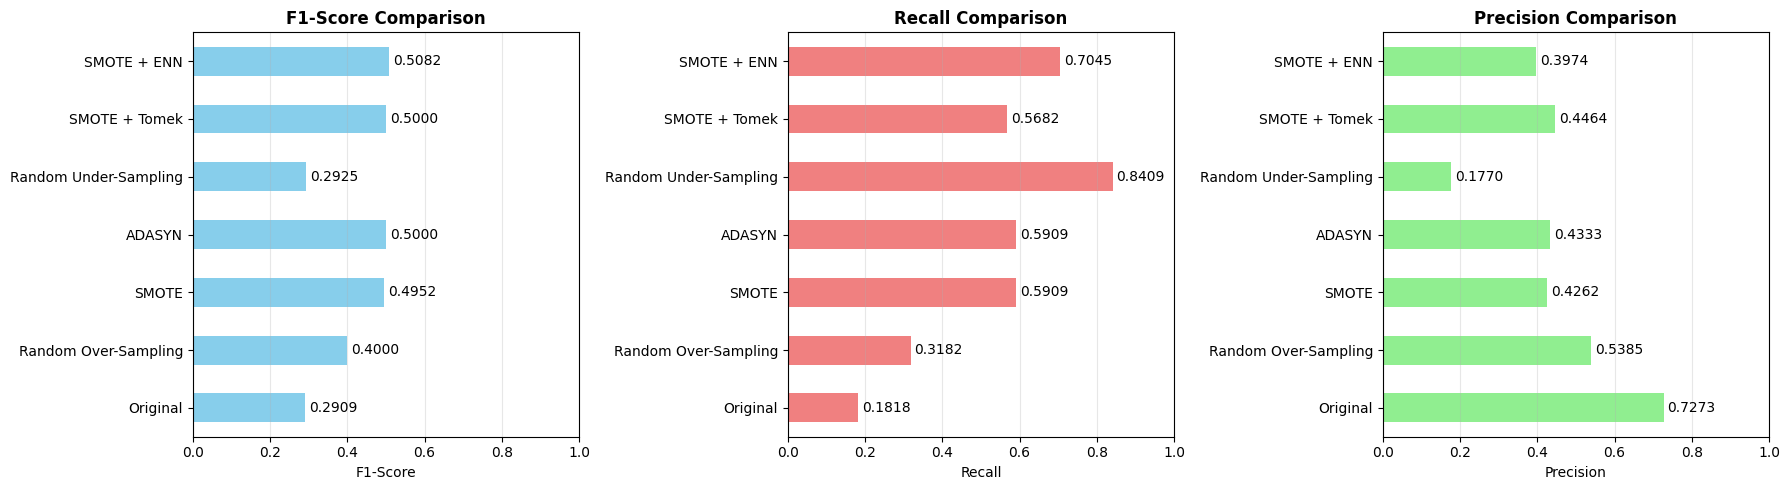


🏆 Best method by F1-Score: SMOTE + ENN
F1-Score: 0.5082
Recall: 0.7045
Precision: 0.3974


In [ ]:
# Create comparison dataframe (exclude predictions and history)
comparison_results = {}
for model_name, metrics in results.items():
    comparison_results[model_name] = {
        'Accuracy': metrics['accuracy'],
        'F1-Score': metrics['f1'],
        'Recall': metrics['recall'],
        'Precision': metrics['precision']
    }

results_df = pd.DataFrame(comparison_results).T
results_df = results_df.round(4)

print("="*70)
print("PERBANDINGAN PERFORMA MODEL")
print("="*70)
print(results_df.to_string())
print("="*70)

# Visualize the comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

metrics = ['Accuracy', 'F1-Score', 'Recall', 'Precision']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    results_df[metric].plot(kind='barh', ax=axes[idx], color=color, alpha=0.8)
    axes[idx].set_title(f'{metric}', fontweight='bold', fontsize=13)
    axes[idx].set_xlabel('Score')
    axes[idx].set_xlim([0, 1])
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(results_df[metric]):
        axes[idx].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.suptitle('Perbandingan Metrik Evaluasi Antar Model', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Find the best model
best_model = results_df['F1-Score'].idxmax()
print(f"\n{'='*70}")
print(f"🏆 MODEL TERBAIK: {best_model}")
print(f"{'='*70}")
for metric in ['Accuracy', 'F1-Score', 'Recall', 'Precision']:
    print(f"{metric:15s}: {results_df.loc[best_model, metric]:.4f}")
print(f"{'='*70}")

### 5.2 Confusion Matrix untuk Setiap Model

In [ ]:
# Plot Confusion Matrix untuk setiap model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = ['Decision Tree', 'Random Forest', 'ANN']
for idx, model_name in enumerate(model_names):
    cm = confusion_matrix(y_test, results[model_name]['predictions'])
    
    # Plot dengan seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar_kws={'label': 'Count'},
                xticklabels=['Sehat (0)', 'Bangkrut (1)'],
                yticklabels=['Sehat (0)', 'Bangkrut (1)'])
    
    axes[idx].set_title(f'Confusion Matrix\n{model_name}', fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Tambahkan informasi TN, FP, FN, TP
    tn, fp, fn, tp = cm.ravel()
    info_text = f'TN={tn} | FP={fp}\nFN={fn} | TP={tp}'
    axes[idx].text(0.5, -0.15, info_text, ha='center', transform=axes[idx].transAxes,
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Confusion Matrix - Perbandingan Model', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# Print detail classification report untuk model terbaik
print("="*70)
print(f"CLASSIFICATION REPORT - {best_model}")
print("="*70)
print(classification_report(y_test, results[best_model]['predictions'], 
                          target_names=['Sehat (0)', 'Bangkrut (1)']))

### 5.3 Feature Importance - Top 5 Variabel Paling Berpengaruh

In [ ]:
# Ambil feature importance dari Random Forest (model tree-based terbaik)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': trained_models['Random Forest'].feature_importances_
}).sort_values('Importance', ascending=False)

# Visualisasi Top 10
plt.figure(figsize=(14, 8))

# Top 10 features
top_10 = feature_importance.head(10)
colors = ['#e74c3c' if i < 5 else '#3498db' for i in range(10)]

plt.barh(range(10), top_10['Importance'].values, color=colors, alpha=0.8)
plt.yticks(range(10), top_10['Feature'].values)
plt.xlabel('Importance Score', fontweight='bold')
plt.title('Top 10 Variabel Paling Berpengaruh terhadap Kebangkrutan Bank', 
          fontweight='bold', fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Tambahkan garis pemisah Top 5
plt.axhline(y=4.5, color='red', linestyle='--', linewidth=2, label='Top 5')
plt.legend()

plt.tight_layout()
plt.show()

# Print Top 5 dengan penjelasan
print("="*70)
print("🎯 TOP 5 VARIABEL PALING BERPENGARUH TERHADAP KEBANGKRUTAN BANK")
print("="*70)
for idx, row in feature_importance.head(5).iterrows():
    print(f"{idx+1}. {row['Feature']}")
    print(f"   Importance Score: {row['Importance']:.6f}")
    print()

---

## 6. KESIMPULAN DAN REKOMENDASI

In [ ]:
print("="*70)
print("📊 KESIMPULAN AKHIR")
print("="*70)

print("\n1️⃣ MASALAH YANG DIHADAPI:")
print("   Bank Sentral Taiwan memerlukan sistem prediksi dini untuk")
print("   mengidentifikasi bank yang berisiko bangkrut sebelum terlambat.")

print("\n2️⃣ DATA UNDERSTANDING:")
print(f"   • Dataset: {df.shape[0]:,} bank dengan {df.shape[1]} indikator finansial")
print(f"   • Target Variable: Bankrupt? (0=Sehat, 1=Bangkrut)")
print(f"   • Data sangat imbalanced (96.77% vs 3.23%)")

print("\n3️⃣ DATA PREPARATION:")
print("   • Tidak ada missing values")
print("   • Menggunakan SMOTE untuk mengatasi imbalanced data")
print("   • Feature scaling dengan StandardScaler")

print("\n4️⃣ MODELING:")
print(f"   • Decision Tree: F1-Score = {results['Decision Tree']['f1']:.4f}")
print(f"   • Random Forest: F1-Score = {results['Random Forest']['f1']:.4f}")
print(f"   • ANN: F1-Score = {results['ANN']['f1']:.4f}")
print(f"   • Model Terbaik: {best_model}")

print("\n5️⃣ EVALUASI:")
print(f"   • Accuracy: {results[best_model]['accuracy']:.4f}")
print(f"   • Precision: {results[best_model]['precision']:.4f}")
print(f"   • Recall: {results[best_model]['recall']:.4f}")
print(f"   • F1-Score: {results[best_model]['f1']:.4f}")

print("\n6️⃣ TOP 5 VARIABEL PALING BERPENGARUH:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {idx+1}. {row['Feature']}")

print("\n" + "="*70)
print("💡 REKOMENDASI")
print("="*70)
print("✅ Implementasikan model untuk early warning system")
print("✅ Monitor 5 indikator kritis secara berkala")
print("✅ Berikan pendampingan intensif pada bank dengan skor risiko tinggi")
print("✅ Update model secara berkala dengan data terbaru")
print("="*70)

# Save model terbaik
import joblib
joblib.dump(trained_models[best_model], f'model_{best_model.replace(" ", "_").lower()}.joblib')
joblib.dump(scaler, 'scaler.joblib')
print(f"\n💾 Model dan scaler tersimpan!")
print(f"   • model_{best_model.replace(' ', '_').lower()}.joblib")
print(f"   • scaler.joblib")

✓ Balanced dataset saved as 'data-bank-balanced-smote.csv'
Shape: (10558, 96)
Class distribution:
Bankrupt?
0    5279
1    5279
Name: count, dtype: int64

✓ Complete balanced dataset saved as 'data-bank-balanced-complete.csv'
Shape: (11922, 96)

✓ Complete balanced dataset saved as 'data-bank-balanced-complete.csv'
Shape: (11922, 96)


---

## APPENDIX: Penjelasan Teknik Balancing

Untuk referensi, berikut adalah teknik-teknik balancing yang telah diuji:

### 1. Random Over-Sampling
- Duplikasi sampel kelas minoritas secara acak
- ✅ Sederhana dan cepat
- ❌ Rentan overfitting

### 2. SMOTE (Synthetic Minority Over-sampling Technique)
- Membuat sampel sintetis berbasis k-nearest neighbors
- ✅ Mengurangi overfitting dibanding random over-sampling
- ✅ Hasil umumnya bagus
- **Digunakan dalam model final**

### 3. ADASYN (Adaptive Synthetic Sampling)
- Fokus pada sampel yang sulit dipelajari
- ✅ Adaptif terhadap distribusi data

### 4. SMOTE + Tomek Links
- Kombinasi over-sampling + pembersihan noise
- ✅ Decision boundary lebih bersih

### 5. SMOTE + ENN
- Pembersihan lebih agresif setelah SMOTE
- ✅ Performa dapat lebih baik

---

### 📚 Referensi Pustaka:
1. Chawla, N.V., et al. (2002). "SMOTE: Synthetic Minority Over-sampling Technique"
2. He, H., et al. (2008). "ADASYN: Adaptive Synthetic Sampling Approach"
3. Breiman, L. (2001). "Random Forests"
4. Goodfellow, I., et al. (2016). "Deep Learning"

---

**Dibuat oleh:** [Nama Mahasiswa]  
**NIM:** [NIM]  
**Tanggal:** 13 November 2025  
**Mata Kuliah:** Artificial Intelligence - Pertemuan 11